# Homework 3

In [60]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric
!pip install networkx
!pip install node2vec

Looking in links: https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
Looking in links: https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html


In [61]:
import os
import networkx as nx
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

Wikipedia Article Networks https://snap.stanford.edu/data/wikipedia-article-networks.html

Read raw data

In [62]:
edgelist = pd.read_csv("musae_chameleon_edges.csv")
edgelist

,id1,id2
0,2034,1939
1,2034,2263
2,2034,1976
3,2034,2234
4,2034,804
...,...,...
36096,1153,881
36097,1153,2153
36098,1153,2186
36099,1153,1520


In [63]:
edgelist['id1'].min()

0

In [64]:
Gnx = nx.from_pandas_edgelist(edgelist, 'id1', 'id2')
Gnx

In [65]:
Gnx

In [66]:
n_nodes = Gnx.number_of_nodes()
n_nodes

2277

In [67]:
M = nx.to_numpy_matrix(Gnx)
M

matrix([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 1., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
len(M)

2277

In [69]:
M.shape

(2277, 2277)

## Use PCA to create node embedding

### 2.1 PCA (10 points)

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca.fit(M)

C:\Users\tamim\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


PCA(n_components=200)

In [71]:
np.transpose(pca.components_)

array([[-0.00140868, -0.00257315,  0.03084033, ...,  0.00199396,
         0.00334925,  0.0001272 ],
       [-0.04393275, -0.05836929,  0.08455253, ...,  0.00016266,
        -0.00901089, -0.00493147],
       [-0.03665626, -0.05076236,  0.1047954 , ...,  0.06754471,
         0.11326194,  0.01640555],
       ...,
       [-0.000174  , -0.00039046,  0.00699179, ...,  0.00051192,
         0.0017964 ,  0.00789227],
       [-0.00323367, -0.00512967,  0.02671906, ...,  0.00181284,
        -0.00150815,  0.00553515],
       [ 0.01029073,  0.00079389,  0.00142693, ...,  0.00170077,
         0.00122545, -0.00699421]])

In [72]:
emb = np.transpose(pca.components_)
emb.shape

(2277, 200)

In [73]:
emb

array([[-0.00140868, -0.00257315,  0.03084033, ...,  0.00199396,
         0.00334925,  0.0001272 ],
       [-0.04393275, -0.05836929,  0.08455253, ...,  0.00016266,
        -0.00901089, -0.00493147],
       [-0.03665626, -0.05076236,  0.1047954 , ...,  0.06754471,
         0.11326194,  0.01640555],
       ...,
       [-0.000174  , -0.00039046,  0.00699179, ...,  0.00051192,
         0.0017964 ,  0.00789227],
       [-0.00323367, -0.00512967,  0.02671906, ...,  0.00181284,
        -0.00150815,  0.00553515],
       [ 0.01029073,  0.00079389,  0.00142693, ...,  0.00170077,
         0.00122545, -0.00699421]])

## Supervised learning

### 2.2 SVM (20 points)

In [74]:
def construct_dataset(pos_edges, n_nodes):

    fake_edges = []

    n = len(pos_edges)
    n_fake = 0
    while True:
        edge = np.random.choice(n_nodes, 2)
        if (edge[0], edge[1]) not in pos_edges:
            fake_edges.append({'id1':edge[0], 'id2': edge[1]})
            n_fake += 1
        if n_fake == n:
            break
    x = pos_edges.append(fake_edges, ignore_index=True)
    y = [1]*len(pos_edges) + [0]*len(fake_edges)
    return x, y

In [75]:
pos_edges = edgelist.sample(n=5000, random_state=1)

In [76]:
X_idx, y = construct_dataset(pos_edges, n_nodes)

In [77]:
X_idx

,id1,id2
0,957,1803
1,722,8
2,240,1569
3,951,905
4,2222,954
...,...,...
9995,96,1228
9996,2193,1914
9997,154,1171
9998,767,917


In [78]:
def hadamard(x, y):
    return x*y

def l1_weight(x, y):
    return np.absolute(x-y)

def l2_weight(x, y):
    return np.square(x-y)

def concate(x, y):
    return np.concatenate((x, y), axis=1)

def average(x, y):
    return (x+y)/2

In [79]:
def create_features(vec):
    node1, node2 = vec
    vec_1, vec_2 = emb[node1,:],emb[node2,:]
    X = hadamard(vec_1, vec_2)
    return pd.Series(X)

In [80]:
X = X_idx.apply(lambda x: create_features(x[['id1','id2']]), axis = 1)

In [81]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [82]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,5.309254e-07,1.290018e-06,0.000086,1.045356e-05,2.516683e-05,6.110658e-06,0.000048,0.000019,5.719399e-05,8.063149e-08,...,-0.000685,-0.000755,1.244899e-03,-4.754614e-04,0.000267,2.282563e-06,0.000329,-0.000172,0.000294,0.000131
1,6.955176e-06,1.913964e-05,0.000684,-4.590287e-05,-8.392346e-05,3.181524e-04,0.000007,0.000005,-2.367790e-04,-7.857085e-07,...,0.000082,0.000080,-3.349318e-06,1.748070e-04,0.000044,2.296977e-05,-0.000066,0.000030,-0.000044,-0.000232
2,2.970827e-07,4.638025e-07,-0.000015,-2.166916e-07,8.941538e-07,3.054200e-07,0.000011,-0.000009,6.714808e-07,-2.437022e-08,...,0.000005,0.000005,3.797150e-07,-7.499373e-07,-0.000035,1.889041e-05,0.000008,0.000030,0.000015,0.000024
3,1.405070e-07,9.385331e-08,-0.000013,2.484717e-07,1.563021e-06,1.968374e-07,0.000013,-0.000008,4.327074e-06,1.415143e-08,...,0.000070,0.000102,5.248029e-04,1.310263e-04,-0.000010,3.864830e-04,0.000183,-0.000056,-0.000584,-0.000160
4,7.382213e-08,2.374134e-07,0.000012,-4.838687e-07,2.276287e-06,2.858640e-06,0.000015,0.000003,5.019090e-06,9.843292e-07,...,0.000257,-0.000012,-2.772126e-05,6.786542e-06,-0.000062,3.123505e-07,0.000039,0.000140,-0.000037,-0.000086


In [83]:
train_X.shape

(8000, 200)

In [84]:
train_y

[0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,


In [85]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_X, train_y)

SVC()

In [87]:
svc.score(test_X, test_y)

0.541

### 2.3 Visualization (10 points)

In [88]:
from sklearn.manifold import TSNE
W_tsne = TSNE().fit_transform(emb)

C:\Users\tamim\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tamim\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


([], [])

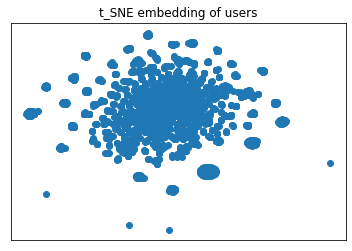

In [89]:
import matplotlib.pyplot as plt
plt.scatter(W_tsne[:, 0], W_tsne[:, 1])
plt.title("t_SNE embedding of users")
plt.xticks(())
plt.yticks(())

### (Optional) Use one of Deepwalk, LINE, node2vec instead of PCA (20 points)

# DeepWak for embedding 

In [90]:
!pip install karateclub

In [91]:
import networkx as nx
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from karateclub import DeepWalk

In [92]:
# train model and generate embedding
model = DeepWalk(walk_length=100, dimensions=200, window_size=5)
model.fit(Gnx)
embedding = model.get_embedding()

In [93]:
embedding.shape

(2277, 200)

In [94]:
embedding 

array([[ 0.17241588,  0.2535318 , -1.1916449 , ...,  0.92083186,
         0.04421682, -0.30619642],
       [ 0.4010889 , -0.37183526, -0.20819952, ..., -0.74379516,
         0.6020347 ,  0.632239  ],
       [ 0.18095605,  1.045459  ,  0.21537228, ...,  1.2617723 ,
        -0.3577499 ,  0.9519622 ],
       ...,
       [-0.11804793, -0.52292794, -0.01950406, ..., -0.37943113,
        -0.42655972,  0.71886545],
       [-0.2665868 ,  0.5138667 ,  1.0917963 , ...,  1.5212904 ,
        -0.3404274 ,  0.865999  ],
       [-0.4420427 , -0.21763626,  0.4686348 , ...,  0.78883415,
         0.18627103, -0.53746915]], dtype=float32)

(2277, 200)


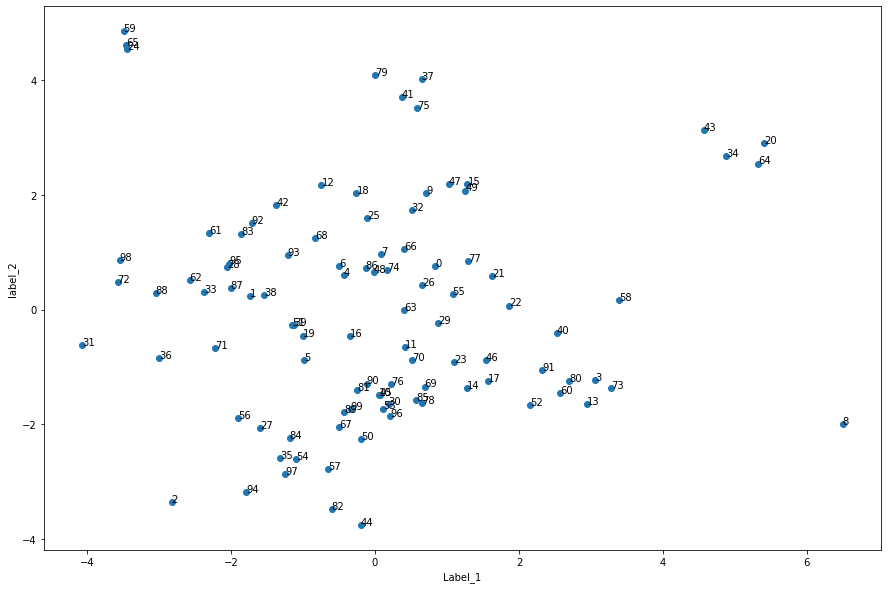

In [96]:
# print Embedding shape
print(embedding.shape)
# take first 100 nodes
nodes =list(range(100))

# plot nodes graph
def plot_nodes(node_no):
    X = embedding[node_no]
    
    pca = PCA(n_components=2)
    pca_out= pca.fit_transform(X)
      
      
    plt.figure(figsize=(15,10))
    plt.scatter(pca_out[:, 0], pca_out[:, 1])
    for i, node in enumerate(node_no):
        plt.annotate(node, (pca_out[i, 0], pca_out[i, 1]))
    plt.xlabel('Label_1')
    plt.ylabel('label_2')
    plt.show()
  
plot_nodes(nodes)

## Supervised learning for DeepWalk

In [98]:
def construct_dataset(pos_edges, n_nodes):

    fake_edges = []

    n = len(pos_edges)
    n_fake = 0
    while True:
        edge = np.random.choice(n_nodes, 2)
        if (edge[0], edge[1]) not in pos_edges:
            fake_edges.append({'id1':edge[0], 'id2': edge[1]})
            n_fake += 1
        if n_fake == n:
            break
    x = pos_edges.append(fake_edges, ignore_index=True)
    y = [1]*len(pos_edges) + [0]*len(fake_edges)
    return x, y

In [99]:
def hadamard(x, y):
    return x*y

def l1_weight(x, y):
    return np.absolute(x-y)

def l2_weight(x, y):
    return np.square(x-y)

def concate(x, y):
    return np.concatenate((x, y), axis=1)

def average(x, y):
    return (x+y)/2

In [100]:
pos_edges = edgelist.sample(n=5000, random_state=1)

In [101]:
X_idx, y = construct_dataset(pos_edges, n_nodes)

In [102]:
X_idx

,id1,id2
0,957,1803
1,722,8
2,240,1569
3,951,905
4,2222,954
...,...,...
9995,1435,2220
9996,874,2248
9997,216,375
9998,1609,10


In [103]:
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [104]:
def create_features(vec):
    node1, node2 = vec
    vec_1, vec_2 = embedding[node1,:],embedding[node2,:]
    X = hadamard(vec_1, vec_2)
    return pd.Series(X)

In [105]:
X = X_idx.apply(lambda x: create_features(x[['id1','id2']]), axis = 1)

In [106]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [107]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.730776,-0.007797,-0.193718,0.073352,-0.051045,0.296475,-0.227675,0.478881,0.009198,-0.370660,...,0.379908,-0.431357,0.019223,0.313662,0.006497,-0.241083,0.209968,0.011843,-0.079716,0.081703
1,0.336563,-0.223756,-0.628171,0.005174,-0.791097,-0.064281,0.062316,0.493802,-0.304297,-1.520288,...,-0.978006,0.029422,0.090541,1.338141,0.092189,0.015389,-0.043061,-0.302138,0.029023,-0.627188
2,0.092953,0.006366,0.036809,0.085961,-0.162241,-0.305044,-0.211418,-0.015870,-0.047805,0.023945,...,0.035429,0.213452,0.070201,0.007639,-0.024608,-0.034547,-0.032247,-0.040094,0.131650,0.273854
3,0.127045,0.062662,-0.011738,0.009278,-0.017395,-0.174567,-0.099571,0.118200,0.014232,0.240847,...,0.631352,-0.064397,0.026116,0.328719,0.010317,0.029263,-0.035049,-0.073818,0.075769,0.012078
4,0.056471,0.117163,-0.416649,-0.258496,-1.377319,-0.276797,-0.445107,0.488678,0.319804,-0.078669,...,0.037607,0.270743,0.376065,-0.034030,0.076341,-0.085346,0.321987,0.019967,0.851458,-0.179958


In [108]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_X, train_y)

SVC()

In [109]:
svc.score(test_X, test_y)

0.9565

# DeepWalk Visulaization

C:\Users\tamim\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tamim\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(array([-80., -60., -40., -20.,   0.,  20.,  40.,  60.,  80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

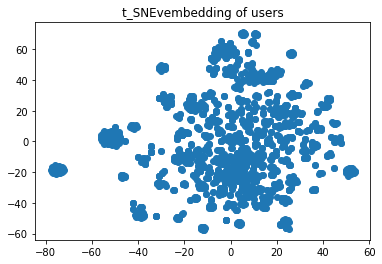

In [110]:
from sklearn.manifold import TSNE
W_tsne = TSNE().fit_transform(embedding)
plt.scatter(W_tsne[:,0], W_tsne[:,1])
plt.title("t_SNEvembedding of users")
plt.xticks()
plt.yticks()